In [ ]:
!pip install kagglehub
!pip install ipympl

In [ ]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [1]:
import pandas as pd
import numpy as np
import kagglehub
from tqdm import tqdm 
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Лабораторная работа 7. Обучение без учителя

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

## Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму. Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).

## EM-алгоритм

### Краудсорсинг

Разметка данных — одна из самых трудозатратных задач в машинном обучении. Краудсорсинг позволяет распределить эту задачу на тысячи исполнителей, каждый из которых подготавливает небольшую часть датасета (подробнее <a href="https://academy.yandex.ru/posts/chto-takoe-kraudsorsing-i-pochemu-emu-nuzhno-uchitsya">тут</a>).

Пользователи могут допускать ошибки при разметке, кроме того, среди пользователей могут быть боты. Если мы попросим разметить каждый объект только одного пользователя, то с большой вероятностью получим не достаточно качественную разметку. Обычно каждый объект размечают несколько пользователей.

Результаты разметки нужно обработать. Самый простой метод *голос большинства*. Он заключается в том, что для каждого объекта нужно взять тот класс, который чаще всего ставили пользователи данному объекту. Это достаточно хороший метод, но он не учитывает различные особенности пользователей. Далее рассмотрим метод, который позволяет оценивать вероятность того, что разметчик ошибся.

### Метод Дэвида-Скина (Dawid, Skene, 1979)

Мы имеем в качестве данных $n_{ik}^u$ &mdash; количество раз, при которых разметчик $u \in U$ поставил класс $k \in K$ объекту $i \in I$ (возможно, разметчик видел этот объект несколько раз). Обозначим $Y_{ik} = I\{\text{объект $i$ класса $k$}\}$, это наши латентные величины. 

В качестве параметров имеем
* $\pi_{k\ell}^u$ &mdash; вероятность того, что разметчик $u$ поставил класс $\ell$ вместо правильного класса $k$. 
* $\rho_k$ &mdash; вероятность класса $k$.

Поймём, какой будет функция неполного правдоподобия в этой задаче. Прежде всего,

$$p_{\pi,p}(N, Y) = \prod_{i\in I}p(N_i, Y_i),$$

Если $k$ - номер класса $i$-го объекта, то

$$p(N_i, Y_i)=\underbrace{p(\text{объект $i$ класса $k$})}_{=\rho_k}p(N_i\mid\text{объект $i$ класса $k$})$$

(значения $Y_{it}$ однозначно определяются номером истинного класса, поэтому справа $Y_i$ пропадает). Далее, мы считаем, что разметчики действуют независимо, поэтому

$$p(N_i\mid\text{объект $i$ класса $k$}) = \prod_{u\in U}p(N_i^u\mid\text{объект $i$ класса $k$}).$$

Разберёмся с величиной $p(N_i^u\mid\text{объект $i$ класса $k$})$. Она отвечает за то, какие классы $u$-й разметчик ставил $i$-му объекту. Мы считаем, что встречи разметчика с объектом упорядочены по времени, тогда

$$p(\text{$u$-й разметчик отнёс $i$-й объект к классам $k'_1,\ldots,k'_r$}\mid\text{объект $i$ класса $k$}) =$$

$$=\prod_{s}p(\text{в $s$-ю встречу с $i$-м объектом $u$-й разметчик отнёс его к классу $k'_s$}\mid\text{объект $i$ класса $k$})$$

Эту вероятность можно переписать в виде

$$\prod_{\ell \in K} \left( \pi_{k\ell}^u \right)^{n_{i\ell}^u},$$

а итоговое неполное правдоподобие предстаёт в виде

$$p_{\pi,p}(N, Y) = \prod_{i\in I}\prod_{k \in K} \left( \rho_k \prod_{u\in U} \prod_{\ell \in K} \left( \pi_{k\ell}^u \right)^{n_{i\ell}^u} \right)^{Y_{ik}}$$

Его нам нужно максимизировать по $\pi$ и $\rho$

**Пояснение к формуле:** 

Вне больших скобок фиксируются объект и его класс, сама скобка возводится в степень 1, если рассматривается правильный класс объекта, и в степень 0 иначе. Внутри сначала записана вероятность того, что объект имеет данный класс, а затем &mdash; перебор по всем пользователям и всем классам, которые мог поставить данный пользователь. Наконец, записывается вероятность того, что пользователь нашему объекту поставил некоторый класс, которая возводится в степень того, сколько раз он поставил этот класс. Например, если пользователь видел изображение котика 5 раз, при этом 3 раза он сказал, что котик, а два раза &mdash; песик, то вероятность $\pi_{cat,cat}^u$ для данного котика учтется 3 раза, а вероятность $\pi_{cat,dog}^u$ &mdash; 2 раза.

**Задание 1 (2 балл)**

Распишите итерационную процедуру EM-алгоритма и значение ELBO в методе Дэвида-Скина.

In [2]:
class DawidSkene:
    def __init__(self, crowd_labels: pd.DataFrame):
        self.crowd_labels = crowd_labels
    
    def initialize_params(self):
        # your code here
    
    def predict(self):
        # your code here
        
    def run(self, n_iter):
        # your code here

IndentationError: expected an indented block after function definition on line 5 (3899311815.py, line 8)

In [20]:


import time

class DawidSkene:
    def __init__(self, crowd_labels: pd.DataFrame):
        """
        Инициализирует модель Dawid-Skene для агрегации меток.
        
        Parameters:
        -----------
        crowd_labels : pd.DataFrame
            Фрейм данных с аннотациями от разметчиков.
            Ожидаемые колонки: 'task-id', 'worker_id', 'label'
        """
        self.crowd_labels = crowd_labels
        self.items = self.crowd_labels['task-id'].unique()
        self.workers = self.crowd_labels['worker-id'].unique()
        self.classes = self.crowd_labels['label'].unique()
        
        self.n_items = len(self.items)
        self.n_workers = len(self.workers)
        self.n_classes = len(self.classes)
        
        # Создадим словари для быстрого доступа
        self.item_to_idx = {item: idx for idx, item in enumerate(self.items)}
        self.worker_to_idx = {worker: idx for idx, worker in enumerate(self.workers)}
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Создадим матрицу меток
        self.labels_matrix = np.ones((self.n_items, self.n_workers)) * -1
        for _, row in crowd_labels.iterrows():
            i = self.item_to_idx[row['task-id']]
            j = self.worker_to_idx[row['worker-id']]
            k = self.class_to_idx[row['label']]
            self.labels_matrix[i, j] = k
        
        # Параметры модели
        self.p_y = None  # априорные вероятности классов
        self.pi = None   # матрицы ошибок разметчиков
        self.T = None    # апостериорные вероятности классов для объектов
    
    def initialize_params(self):
        s = 0.1
        """
        Инициализирует параметры модели:
        - p_y: априорные вероятности классов
        - pi: матрицы ошибок для каждого разметчика
        - T: апостериорные вероятности истинных меток
        """
        # Инициализируем априорные вероятности равномерно
        self.p_y = np.ones(self.n_classes) / self.n_classes
        
        # Инициализируем матрицы ошибок для каждого разметчика
        # Предполагаем, что разметчики в основном правы (0.7 на диагонали)
        eror_init = s+np.random.rand()/(1/(1-2*s))
        error_rate = eror_init / (self.n_classes - 1)  # равномерное распределение ошибок
        self.pi = np.ones((self.n_workers, self.n_classes, self.n_classes)) * error_rate
        for w in range(self.n_workers):
            np.fill_diagonal(self.pi[w], 1 - eror_init)  # диагональные элементы = 0.7
        
        # Инициализируем апостериорные вероятности меток (E-шаг)
        self.T = np.ones((self.n_items, self.n_classes)) / self.n_classes
    
    def e_step(self):
        """
        E-шаг: Обновляет апостериорные вероятности истинных меток (T)
        на основе текущих значений параметров p_y и pi.
        
        Возвращает значение ELBO для мониторинга сходимости.
        """
        log_likelihood = 0
        
        for i in range(self.n_items):
            # Начинаем с априорных вероятностей
            log_p = np.log(self.p_y + 1e-10)
            
            # Для каждого разметчика, который оценил этот объект
            for j in range(self.n_workers):
                if self.labels_matrix[i, j] >= 0:  # если разметчик поставил метку
                    label_idx = int(self.labels_matrix[i, j])
                    for c in range(self.n_classes):
                        log_p[c] += np.log(self.pi[j, c, label_idx] + 1e-10)
            
            # Вычисляем вероятности и нормализуем
            p = np.exp(log_p - np.max(log_p))  # Стабилизация вычислений
            self.T[i] = p / np.sum(p)
            
            # Обновляем значение правдоподобия для ELBO
            log_likelihood += np.sum(self.T[i] * log_p)
        
        # Вычисляем ELBO
        entropy = -np.sum(self.T * np.log(self.T + 1e-10))
        elbo = log_likelihood + entropy
        
        return elbo
    
    def m_step(self):
        """
        M-шаг: Обновляет параметры модели (p_y и pi)
        на основе текущих апостериорных вероятностей T.
        """
        # Обновляем априорные вероятности классов
        self.p_y = np.mean(self.T, axis=0)
        
        # Обновляем матрицы ошибок для каждого разметчика
        for j in range(self.n_workers):
            for c_true in range(self.n_classes):
                # Для каждого истинного класса c_true
                # находим все объекты, оцененные разметчиком j
                mask = (self.labels_matrix[:, j] >= 0)
                if not np.any(mask):
                    continue
                
                # Для всех возможных меток, которые разметчик мог поставить
                for c_obs in range(self.n_classes):
                    # Находим объекты, которые разметчик j пометил как c_obs
                    obs_mask = (self.labels_matrix[:, j] == c_obs)
                    
                    # Обновляем вероятность, что разметчик j пометит как c_obs,
                    # если истинный класс c_true
                    numerator = np.sum(self.T[obs_mask, c_true])
                    denominator = np.sum(self.T[mask, c_true])
                    
                    if denominator > 0:
                        self.pi[j, c_true, c_obs] = numerator / denominator
                    else:
                        # Если нет данных, оставляем равномерное распределение
                        self.pi[j, c_true, c_obs] = 1.0 / self.n_classes
    
    def predict(self):
        """
        Возвращает предсказанные истинные метки для объектов.
        
        Returns:
        --------
        pd.DataFrame: Фрейм данных с колонками 'item_id' и 'true_label'
        """
        # Выбираем класс с максимальной апостериорной вероятностью
        predicted_classes = np.argmax(self.T, axis=1)
        
        # Преобразуем индексы классов обратно в исходные метки
        idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}
        predictions = [idx_to_class[idx] for idx in predicted_classes]
        
        # Создаем DataFrame с результатами
        results = pd.DataFrame({
            'task-id': self.items,
            'true_label': predictions
        })
        
        return results
    
    def run(self, n_iter=10):
        """
        Запускает EM-алгоритм на заданное количество итераций.
        
        Parameters:
        -----------
        n_iter : int, default=10
            Количество итераций EM-алгоритма.
            
        Returns:
        --------
        list: История значений ELBO для мониторинга сходимости.
        """
        # Инициализируем параметры
        self.initialize_params()
        
        # История ELBO для мониторинга сходимости
        elbo_history = []
        epoches = []

        # plt.ion()
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        # elbo_line, = ax.plot([], [], 'r-', label='ELBO')
        # ax.grid(True)
        # plt.tight_layout()
        # fig.canvas.draw()
        
        # Итерационный процесс EM-алгоритма
        for i in tqdm(range(n_iter)):
            # E-шаг: Обновляем апостериорные вероятности истинных меток
            elbo = self.e_step()
            elbo_history.append(elbo)
            epoches.append(i)
            
            # M-шаг: Обновляем параметры модели
            self.m_step()

            clear_output(wait=True)
            plt.close(fig)  # Закрываем предыдущий график
            
            # Создаем новый
            fig, ax = plt.subplots(1, 1, figsize=(12, 5))
            
            # График потерь
            ax.plot(elbo_history, 'b-')
            # ax.set_title('Training Loss')
            # ax.set_xlabel('Epoch')
            ax.grid(True)
            
            plt.tight_layout()
            plt.show()

            # ax.relim()
            # ax.autoscale_view()
            time.sleep(1)
        plt.show()
        # plt.ioff()
        
        return elbo_history


**Задание 2 (3 балла)** 

Реализуйте следующие методы агрегации результатов разметки в краудсорсинге:

* голосование по большинству;
* метод Дэвида-Скина.

Оба метода должны возвращать вероятность принадлежности объекта каждому из классов (итоговая метка получается выбором класса с наибольшей оценкой вероятности). 

Заметим, что метод голосования по большинству можно реализовать с помощью одной агрегирующей функцией `pandas.crosstab`, а метод Дэвида-Скина основывается на EM-алгоритме (при реализации стоит учесть, что EM-алгоритм сходится в локальные оптимумы, то есть его стоит запускать из разных начальных приближений).

Примените эти два метода к датасетам *Toloka Aggregation Relevance 2* и *Toloka Aggregation Relevance 5*, которые можно скачать <a href="https://toloka.ai/ru/datasets">тут</a>, и сравните их между собой. 

Обратите внимание, что в последнем датасете 5 различных меток, причем некоторые объекты в датасете имеют не один, а несколько правильных ответов. Любой из таких ответов считается правильным.

**В Я.Контест нужно загрузить только .csv файлы в следующем формате.**

In [4]:
# Download latest version
path = kagglehub.dataset_download("valentinbiryukov/tlkagg2")

print("Path to dataset files:", path)


Path to dataset files: /Users/sokolov-kir-b/.cache/kagglehub/datasets/valentinbiryukov/tlkagg2/versions/1


In [5]:
# Download latest version
path = kagglehub.dataset_download("valentinbiryukov/toloka-aggregation-relevance-5")

print("Path to dataset files:", path)

Path to dataset files: /Users/sokolov-kir-b/.cache/kagglehub/datasets/valentinbiryukov/toloka-aggregation-relevance-5/versions/1


In [6]:
def majority_vote_agg(df: pd.DataFrame) -> pd.DataFrame:
    result = pd.crosstab(df['task-id'],df['label']).idxmax(axis =1)
    return result.to_frame()

#### TlkAgg2

In [7]:
tikagg2_crowd = pd.read_csv('./tlkagg2/versions/1/crowd_labels.tsv',sep='\t',names=['worker-id', 'task-id','label'])
tikagg2_golden = pd.read_csv('./tlkagg2/versions/1/golden_labels.tsv',sep='\t',names=['task-id','label'])

In [8]:
tikagg2_crowd.head()

,worker-id,task-id,label
0,w851,t30685,1
1,w6991,t30008,0
2,w2596,t36316,0
3,w5507,t15145,1
4,w2982,t44785,1


In [9]:
tikagg2_golden.head()

,task-id,label
0,t30006,0
1,t33578,0
2,t22462,1
3,t52093,0
4,t26935,0


In [10]:
tikagg2_maj_pred = majority_vote_agg(tikagg2_crowd)
tikagg2_maj_pred.columns = ['prediction']
tikagg2_maj_pred.index.name = 'object'
tikagg2_maj_pred

,prediction
object,
t0,1
t1,1
t10,1
t100,0
t1000,0
...,...
t9995,1
t9996,0
t9997,0


In [11]:
tikagg2_maj_pred.to_csv('tikagg2_maj_pred.csv',sep=',')

##### Метод Дэвида-Скина

In [49]:
tikagg2_david_skene = DawidSkene(tikagg2_crowd)

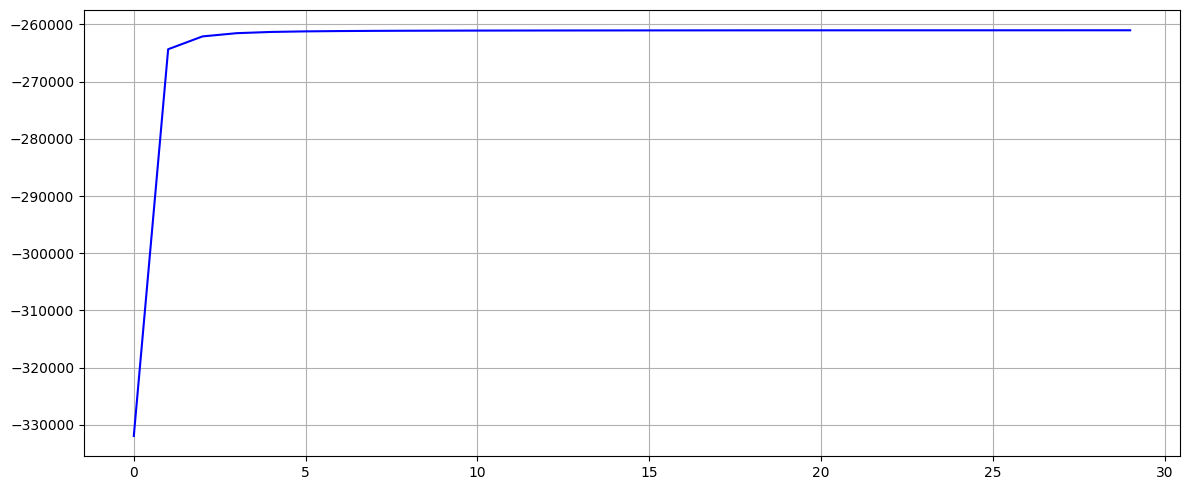

100%|██████████| 30/30 [34:08<00:00, 68.29s/it]


[np.float64(-331948.83184989705),
 np.float64(-264342.1184851637),
 np.float64(-262100.12428047598),
 np.float64(-261531.60289250276),
 np.float64(-261319.3221864554),
 np.float64(-261219.14050096538),
 np.float64(-261163.83853624057),
 np.float64(-261130.03516937018),
 np.float64(-261108.00979629086),
 np.float64(-261092.81965769603),
 np.float64(-261081.72688712645),
 np.float64(-261073.1923350047),
 np.float64(-261066.29910761057),
 np.float64(-261060.45552694149),
 np.float64(-261055.24828483854),
 np.float64(-261050.4079074217),
 np.float64(-261045.945361429),
 np.float64(-261042.24354100737),
 np.float64(-261039.5231004796),
 np.float64(-261037.5347972741),
 np.float64(-261035.98591238167),
 np.float64(-261034.72178427075),
 np.float64(-261033.66310118418),
 np.float64(-261032.76034304587),
 np.float64(-261031.9777974277),
 np.float64(-261031.28880626897),
 np.float64(-261030.67515780588),
 np.float64(-261030.12743913053),
 np.float64(-261029.6434216006),
 np.float64(-261029.2228

In [50]:
tikagg2_david_skene.run(30)

In [51]:
print('Обучение закончилось')

Обучение закончилось


In [52]:
tikagg2_david_skene.predict().head()

,task-id,true_label
0,t30685,1
1,t30008,0
2,t36316,0
3,t15145,1
4,t44785,0


In [53]:
tikagg2_em_pred = tikagg2_david_skene.predict()
tikagg2_em_pred.columns = ['object','prediction']
tikagg2_em_pred = tikagg2_em_pred.set_index('object')
tikagg2_em_pred

,prediction
object,
t30685,1
t30008,0
t36316,0
t15145,1
t44785,0
...,...
t95222,0
t83525,0
t49227,0


In [54]:
tikagg2_em_pred.to_csv('tikagg2_em_pred.csv',sep=',')

#### TlkAgg5

In [33]:
tikagg5_crowd = pd.read_csv('./toloka-aggregation-relevance-5/versions/1/crowd_labels.tsv',sep='\t',names=['worker-id', 'task-id','label'])
tikagg5_golden = pd.read_csv('./toloka-aggregation-relevance-5/versions/1/golden_labels.tsv',sep='\t',names=['task-id','label'])

In [34]:
tikagg5_crowd.head()

,worker-id,task-id,label
0,w360,t186849,4
1,w43,t174611,5
2,w1040,t198665,3
3,w618,t63171,5
4,w98,t141574,5


In [35]:
tikagg5_golden.head()

,task-id,label
0,t342646,2
1,t189317,4
2,t48377,5
3,t73830,3
4,t60415,2


In [36]:
tikagg5_maj_pred = majority_vote_agg(tikagg5_crowd)
tikagg5_maj_pred.columns = ['prediction']
tikagg5_maj_pred.index.name = 'object'
tikagg5_maj_pred

,prediction
object,
t0,3
t1,5
t10,5
t100,5
t1000,5
...,...
t99995,4
t99996,3
t99997,5


In [37]:
tikagg5_maj_pred.to_csv('tikagg5_maj_pred.csv',sep=',')

##### Метод Дэвида-Скина

In [42]:
tikagg5_david_skene = DawidSkene(tikagg5_crowd)

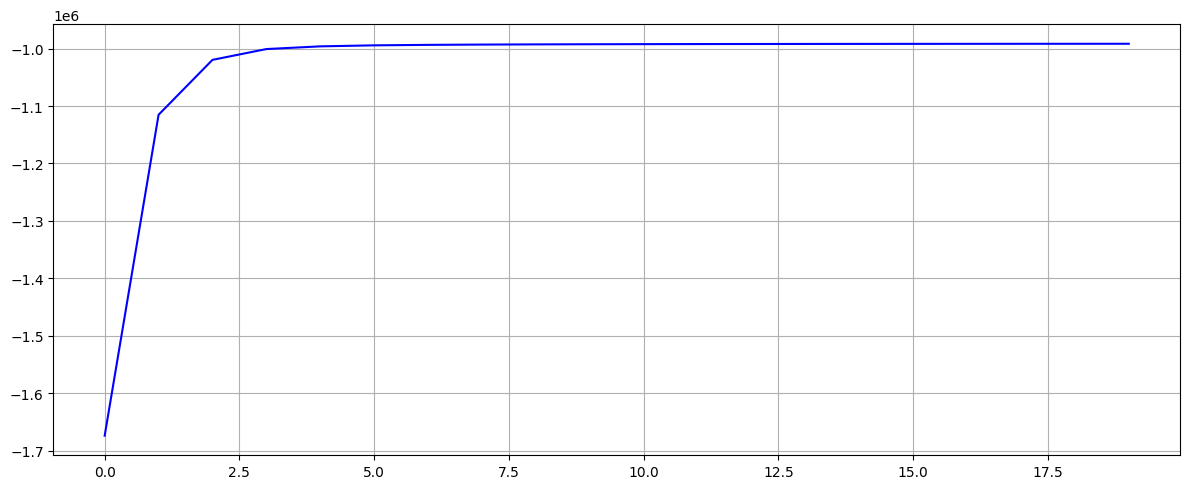

100%|██████████| 20/20 [44:25<00:00, 133.28s/it]


[np.float64(-1673441.3644293465),
 np.float64(-1115219.0652192328),
 np.float64(-1019708.3895392929),
 np.float64(-1000940.7231378639),
 np.float64(-996237.0599034096),
 np.float64(-994475.1276490318),
 np.float64(-993641.4915704941),
 np.float64(-993142.7063164796),
 np.float64(-992805.3903355179),
 np.float64(-992562.89146807),
 np.float64(-992382.0763465093),
 np.float64(-992243.239651822),
 np.float64(-992133.2264599975),
 np.float64(-992043.405465949),
 np.float64(-991968.5601156754),
 np.float64(-991905.4521879298),
 np.float64(-991851.6493170941),
 np.float64(-991805.2778591737),
 np.float64(-991764.8485521141),
 np.float64(-991729.1868101428)]

In [43]:
tikagg5_david_skene.run(20)

In [44]:
print('Обучение закончилось')

Обучение закончилось


In [45]:
tikagg5_david_skene.predict().head()

,task-id,true_label
0,t186849,4
1,t174611,3
2,t198665,3
3,t63171,4
4,t141574,5


In [46]:
tikagg5_em_pred = tikagg5_david_skene.predict()
tikagg5_em_pred.columns = ['object','prediction']
tikagg5_em_pred = tikagg5_em_pred.set_index('object')
tikagg5_em_pred

,prediction
object,
t186849,4
t174611,3
t198665,3
t63171,4
t141574,5
...,...
t78533,5
t3642,3
t323857,3


In [47]:
tikagg5_em_pred.to_csv('tikagg5_em_pred.csv',sep=',')

**Задание 3 (1 балл)** 

Попробуйте в методе Дэвида-Скина в качестве начального приближения вероятностей классов для каждого объекта подавать те вероятности, которые посчитаны методом голосования по большинству, и провести сначала M-шаг.

In [ ]:
class DawidSkeneWithMVInit(DawidSkene):
    def initialize_params(self):
        # your code here

Далее мы будем работать с таблицей `vacancies.csv` и нам нужно подготовить данные для работы, а именно сделайте следующее:
    
- Разбейте данные на обучающую выборку (строки, не содержащие метки кластеров) и тестовую (строки, содержащие метки кластеров)
- Предобработайте текст, содержащийся в колонках *name* и *description* (уберите артефакты, нормализуйте и т.д.)

### Тематическое моделирование

Тематическое моделирование заключается в поиске тем $T$, которые хорошо бы описывали документы $D$ со словарём $W$. Большинство тематических моделей оперирует данными в формате "мешка слов", т.е. учитывают только частоты слов в документах, а не их порядок. Одной из простейших тематических моделей является [PLSA](https://en.wikipedia.org/wiki/Probabilistic_latent_semantic_analysis), которая приводит к задаче стохастического матричного разложения: 

$$F \approx \Phi \times \Theta$$
где
- $F_{W \times D}$— матрица распределений слов в документах (нормированные частоты)
- $\Phi_{W \times T}$ — матрица распределений слов в темах (модель)
- $\Theta_{T \times D}$ — матрица распределений тем в документах (результат применения модели к обучающим данным)

Можно сказать, что алгоритмы тематического моделирования производят мягкую бикластеризацию данных:
 - *мягкую*, так как объекты относятся не строго к одному кластеру, а к нескольким с разными вероятностями
 - *бикластеризацию*, так как модель одновременно кластеризует слова по темам и темы по документам.
 
 С вероятностной точки зрения, задача обучения модели PLSA ставится как максимизация неполного правдоподобия по параметам $\Phi$ и $\Theta$. ЕМ-алгоритм для модели PLSA заключается в повторении двух шагов:

- **Е-шаг** — оценка распределений тем для каждого слова в каждом документе по параметрам $\Phi$ и $\Theta$ (шаг 6);
- **М-шаг** — обновление параметров $\Phi$ и $\Theta$ на основе полученных оценок (шаги 7 и 9).

Существуют различные модификации итерационного процесса, позволяющие снизить расходы по памяти. В данном случае, мы избежим хранения трехмерной матрицы $p_{tdw}$, сразу пересчитывая $\Theta$ для текущего документа и аккумулируя счетчики $n_{wt}$ для последующего пересчета $\Phi$.

Псевдокод алгоритма записывается следующим образом:

1. Инициализировать $\phi_{wt}^0$ для всех $w \in W$, $t \in T$ и $\theta_{td}^0$ для всех $t \in T$, $d \in D$
2. Внешний цикл по итерациям $i = 1 ... max\_iter$:
3. $\quad$ $n_{wt}^i := 0$, $n_t^i := 0$ для всех $w \in W$ и $t \in T$ 
4. $\quad$ Внутренний цикл по документам $d \in D$  
5. $\qquad$ $Z_w := \sum_{t \in T} \phi_{wt}^{i-1}\theta_{td}^{i-1}$ для всех $w \in d$ $\cfrac{}{}$
6. $\qquad$ $p_{tdw} := \cfrac{ \phi_{wt}^{i-1}\theta_{td}^{i-1} }{ Z_w }$ (**E-шаг**)
7. $\qquad$ $\theta_{td}^{i} := \cfrac{ \sum_{w \in d} n_{dw} p_{tdw} }{ n_d }$ для всех $t \in T$ (**M-шаг**)
8. $\qquad$ Увеличить $n_{wt}^i$ и $n_t^i$ на $n_{dw} p_{tdw}$ для всех $w \in W$ и $t \in T$
9. $\quad \phi_{wt}^i := \cfrac{n_{wt}^i}{n_t^i}$ для всех $w \in W$ и $t \in T$ (**M-шаг**)

Обозначения:
 - $p_{tdw}$ — вероятность темы $t$ для слова $w$ в документе $d$
 - $\phi_{wt}$ — элемент матрицы $\Phi$, соответствующий вероятности слова $w$ в теме $t$
 - $\theta_{td}$ — элемент матрицы $\Theta$, соответствующий вероятности темы $t$ в документе $d$
 - $n_{wt}$ — элемент матрицы счётчиков отнесения слова $w$ к теме $t$ (путем нормирования этой матрицы получается матрица $\Phi$)
 - $Z_w$ — элемент вектора вспомогательных переменных, соответствующий слову $w$
 - $n_t$ — вектор нормировочных констант для матрицы $n_{wt}$
 - $n_d$ — вектор нормировочных констант для матрицы $n_{dw}$
 - $n$ — суммарное число слов в коллекции

Для оценивания качества построенной модели и контроля сходимости процесса обучения обычно используют [перплексию](http://www.machinelearning.ru/wiki/images/8/88/Voron-iip9-talk.pdf):

$$\mathcal{P} = \exp\bigg(- \frac{\mathcal{L}}{n} \bigg) = \exp\bigg(- \cfrac{1}{n}\sum_{d \in D}\sum_{w \in d} n_{dw} \ln \big(\sum_{t \in T}\phi_{wt}\theta_{td} \big)\bigg)$$

Это традиционная мера качества в тематическом моделировании, которая основана на правдоподобии модели $\mathcal{L}$. Число итераций $max\_iter$ в алгоритме обучения следует выбирать достаточным для того, чтобы перплексия перестала существенно убывать. Однако известно, что перплексия плохо отражает интерпретируемость найденных тем, поэтому помимо нее обычно используются дополнительные меры или экспертные оценки.

**Рекомендации к реализации:**

- При делении на нулевые значения нужно просто заменить частное на ноль.
- ЕМ-алгоритм стоит реализовывать с использованием векторных операций. Для проверки корректности реализации сперва можно написать скалярную версию, после чего векторизовать её, удостоверившись, что обе реализации дают одинаковый результат. Невекторизованный алгоритм может работать в сотни раз медленнее векторизованного, и его использование может привести к невозможности выполнения задания.
- Итерационный процесс следует начинать, инициализировав матрицы $\Phi$ и $\Theta$. Инициализация может быть случайной, важно не забыть отнормировать столбцы матриц.
- Неэффективная реализация перплексии может в разы замедлить работу алгоритма.

**Задание 4 (3 балла)** 

Реализуйте описанный выше ЕМ-алгоритм для модели *PLSA* и добавьте в вашу реализацию подсчёт перплексии. 

Примените ваш алгоритм к подготовленным ранее данным (объедините текст из колонок *name* и *description*), рассмотрев число тем T = 5, а также:

* Постройте график значения перплексии в зависимости от итерации (убедитесь в корректности реализации: график перплексии должен быть невозрастающим). 
* Выведите для каждой темы топ-20 наиболее вероятных слов.

Посмотрите внимательно на полученные темы. Как вам кажется, получились ли они интерпретируемыми?

In [ ]:
class PLSA:
    def __init__(self, counts: np.matrix, T: int):
        self.counts = counts
        self.T = T

        # your code here

        initialize_params()
    
    def initialize_params(self):
        self.Phi = # your code here
        self.Theta = # your code here

    def step(self):
        # your code here

    def perplexity(self) -> float:
        # your code here

**Задание 5 (1 балл)** 

Рассмотрите большее число тем (10, 20) и несколько различных начальных приближений. Проанализируйте результаты и ответьте на следующие вопросы: 

- Mожно ли сказать, что интерпретируемость каждой темы изменяется с ростом их числа?
- Устойчив ли алгоритм к начальному приближению на примере идентичности топовых слов в соответствующих темах?
- Отражает ли перплексия качество получаемых моделей? В чём заключается причина хорошего/плохого соответствия?

## Кластеризация

**Задание 6 (2 балла)** 

В данном задание следуют сравнить между собой алгоритмы [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [DBSCAN](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) и [Birch](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html) используя подготовленные ранее данные.

Поэксперементируйте с различными способами векторизации текста, например можно:

- использовать только *name* / *description*, объединить их в один текст или сконкатенировать векторные представления,
- использовать представление в виде мешка слов или какую-либо его модификацию,
- сократить размерность векторного представления, используя PCA или векторные представления слов,

или сделать что-то более интересное, что вы придумаете!

Выберете лучшую комбинацию векторизации и алгоритма кластеризации и визуализируйте полученные кластеры (например, воспользовавшись облаком тегов, или предложите свой способ). Обоснуйте почему вы считаете, что выбранный вами подход для решения задачи кластеризации вакансий является лучшим.

**Задание "со звездочкой" (1 балл)** 

Попробуйте обогатить векторное представление полученное из текстов другими признаками из таблицы `vacancies.csv` и добиться лучшей интерпретируемости кластеров.

## Частичное обучение

Часто у нас есть размеченная выборка только для небольшой части выборки. Тогда мы можем применить подходы _частичного обучения (semi-supervised learning)_. Более подробно про реализацию таких методов в sklearn можно прочитать в разделе [semi-supervised](http://scikit-learn.org/stable/modules/label_propagation.html#semi-supervised).

**Задание 7 (2 балла)** 

В этом задание нужно сделать следующее: 

- Разделите объекты, у которых существуют метки, на обучающую и тестовую выборки (при этом не обязательно делить в соотношении 70% на 30%). Обогатите обучающую выборку объектами без меток.
- Воспользовавшись опытом выполнения задания 6, возьмите "лучшее" векторное представление вакансий и обучите [LabelSpreading](http://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html) (подберите лучшие параметры, опираясь на [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)).
- Попробуйте запустить алгоритм несколько раз, отмечая известными различные объекты, а также меняя пропорции разбиения, посчитайте качество и визуализируйте результаты. Можно ли сказать что алгоритм сильно зависит от известных начальных объектов? Есть ли класс, для которого это больше всего заметно?